In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor, export_graphviz, export_text
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\90535\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df = pd.read_csv('Reviews.csv')

In [3]:
df["ProfileName"].head(50)

0                          delmartian
1                              dll pa
2     Natalia Corres "Natalia Corres"
3                                Karl
4       Michael D. Bigham "M. Wassir"
5                      Twoapennything
6                   David C. Sullivan
7                  Pamela G. Williams
8                            R. James
9                       Carol A. Reed
10                       Canadian Fan
11             A Poeng "SparkyGoHome"
12                                 LT
13                    willie "roadie"
14                Lynrie "Oh HELL no"
15                       Brian A. Lee
16                     Erica Neathery
17                              Becca
18                            Wolfee1
19                               Greg
20                           mom2emma
21                     Tammy Anderson
22                      Charles Brown
23                             Mare's
24        S. Cabanaugh "jilly pepper"
25       Deborah S. Linzer "Cat Lady"
26          

In [4]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [5]:
df[df["HelpfulnessDenominator"] > 15].describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,11471.000000,11471.000000,11471.000000,11471.000000,1.147100e+04
mean,287120.518525,29.154215,35.411647,3.451748,1.248235e+09
std,160896.029605,43.766227,44.494979,1.739410,5.745141e+07
min,33.000000,0.000000,16.000000,1.000000,9.482400e+08
25%,153149.000000,15.000000,18.000000,1.000000,1.208909e+09
50%,288294.000000,19.000000,23.000000,4.000000,1.256083e+09
75%,425973.500000,30.000000,35.000000,5.000000,1.293149e+09
max,568276.000000,866.000000,923.000000,5.000000,1.350605e+09


Since the comments with more than 15 helpfulness numbers will be examined in the continuation of the study, this has been considered.

In [6]:
len(df.ProductId.unique())

74258

In [7]:
len(df.UserId.unique())

256059

There are 74258 distinct products and 256059 distinct users in this dataframe

In [8]:
df.dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

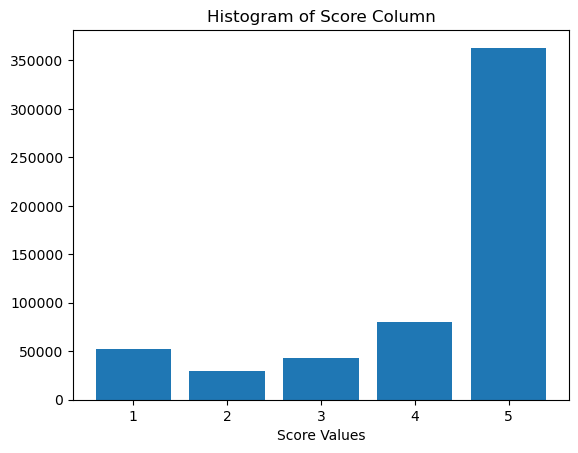

In [9]:
plt.bar(*np.unique(df["Score"], return_counts=True))
plt.title('Histogram of Score Column')
plt.xlabel('Score Values')
plt.show()

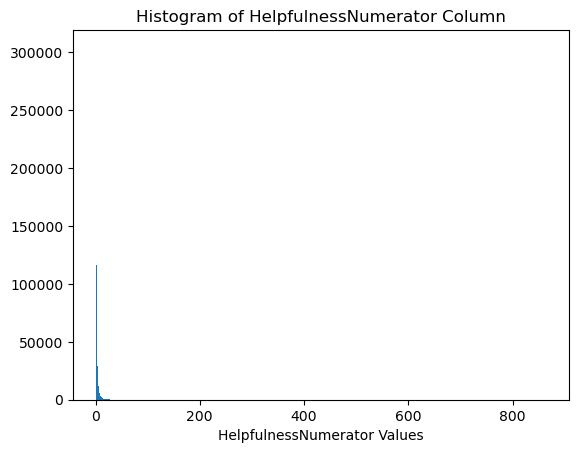

In [10]:
plt.hist(df["HelpfulnessNumerator"],bins=np.arange(min(df["HelpfulnessNumerator"]), max(df["HelpfulnessNumerator"])))
plt.title('Histogram of HelpfulnessNumerator Column')
plt.xlabel('HelpfulnessNumerator Values')
plt.show()

Most of this data is between values between 0-200. It is shown in the boxplot chart below.

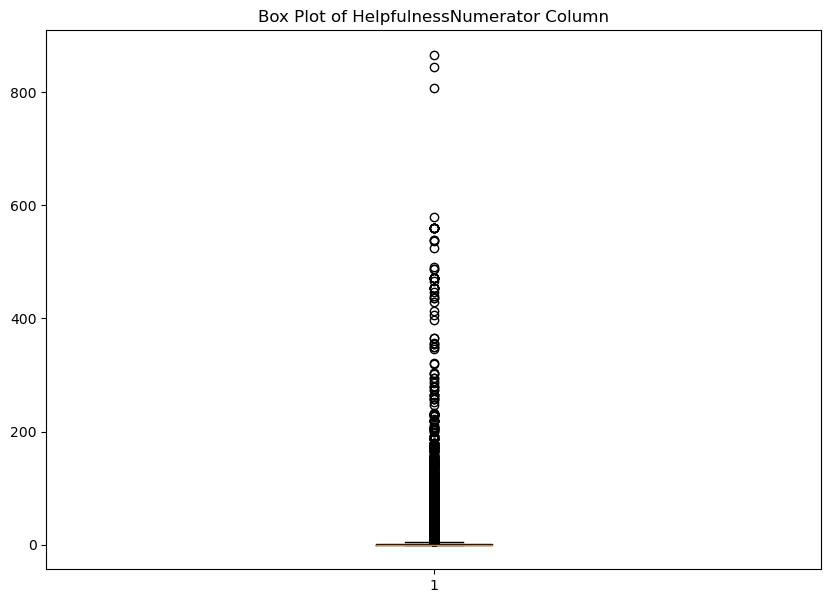

In [11]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot(df["HelpfulnessNumerator"])
plt.title('Box Plot of HelpfulnessNumerator Column')
plt.show()

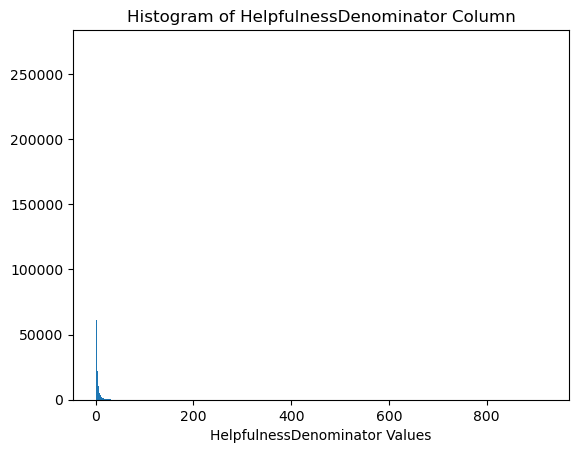

In [12]:
plt.hist(df["HelpfulnessDenominator"],bins=np.arange(min(df["HelpfulnessDenominator"]), max(df["HelpfulnessDenominator"])))
plt.title('Histogram of HelpfulnessDenominator Column')
plt.xlabel('HelpfulnessDenominator Values')
plt.show()

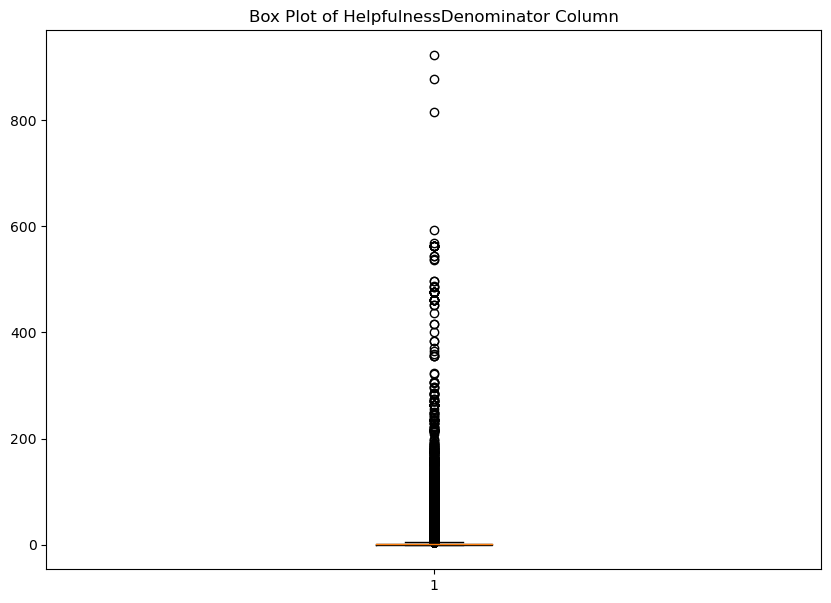

In [13]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot(df["HelpfulnessDenominator"])
plt.title('Box Plot of HelpfulnessDenominator Column')
plt.show()

In [14]:
df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

Only the profile name and summary features have null values. Since these columns will not be used in the future, it is okay to keep them as empty values.

In [15]:
pip install --upgrade language_tool_python

Note: you may need to restart the kernel to use updated packages.


In [16]:
import language_tool_python

In [17]:
tool = language_tool_python.LanguageTool('en-US')

Using the language tool, the total grammar errors in a comment will be checked, as well as whether the profile names are formal or not. Thanks to the tool, it is possible to check whether profile names are in the form of name-surname. If there is any typo, it will be assumed to be an informal profile name.

In [18]:
v_c = ["B007JFMH8M","B0026RQTGE","B003B3OOPA","B001EO5Q64","B000VK8AVK","B000KV7ZGQ","B0013A0QXC","B0090X8IPM","B007Y59HVM","B006MONQMC","B002IEVJRY","B000PDY3HI","B001VJ0B0I","B002LANN56","B008FHUGNQ","B000CNB4LE","B006MONQMC","B0041NYV8E","B000H0ZJHW","B003D4IYSU","B004EAGP74"]

In [19]:
df = df[df["ProductId"].isin(v_c)]

The 10 products with the most comments were selected for analysis and model setup, and the dataframe was created with them. At the same time, comments with a Helpfulness Denominator value higher than 0 were received.

In [20]:
df = df[df["HelpfulnessDenominator"] > 0]

In [21]:
stopwords_english = stopwords.words('english') 

In [22]:
counts = dict()
for text in df["Text"]:
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    words = text.split()

    for word in words:
        if word in stopwords_english:
            continue
        else:
            if word in counts:
                counts[word] += 1
            else:
                counts[word] = 1

In [23]:
words = []
for (key, value) in counts.items():
    if value > 100:
        words.append(key)
        

More than 100 times past words have been selected

In [24]:
sid = SentimentIntensityAnalyzer()

In [25]:
df["Sentiment_score_neu"] = df["Text"].apply(lambda x: sid.polarity_scores(x)["neu"])

In [26]:
df["Sentiment_score_neg"] = df["Text"].apply(lambda x: sid.polarity_scores(x)["neg"])

In [27]:
df["Sentiment_score_pos"] = df["Text"].apply(lambda x: sid.polarity_scores(x)["pos"])

In [28]:
df["Sentiment_scores"] = df["Text"].apply(lambda x: sid.polarity_scores(x))

In [29]:
df["Text"] = df["Text"].apply(lambda x: x.lower().translate(str.maketrans('', '', string.punctuation)))

In [30]:
important_words = []
for wrd in words:
    contains_words_df = df[df["Text"].str.contains(wrd)]
    not_contains_word_df = df[~df["Text"].str.contains(wrd)]
    contains_words_df["contains_neu_scores"] = contains_words_df["Sentiment_scores"].apply(lambda x: x["neu"])
    not_contains_word_df["contains_neu_scores"] = not_contains_word_df["Sentiment_scores"].apply(lambda x: x["neu"])
    test_stat1,p_value_1 = shapiro(contains_words_df.loc[:,"contains_neu_scores"])
    test_stat2,p_value_2 = shapiro(not_contains_word_df.loc[:,"contains_neu_scores"])
    if p_value_1 < 0.05 or p_value_2 < 0.05:
        res = mannwhitneyu(contains_words_df.loc[:,"contains_neu_scores"],not_contains_word_df.loc[:,"contains_neu_scores"])
        if res[1] < 0.05:
            important_words.append(wrd)
        else:
            continue
    else:
        test_stat3,p_value_3 = levene(contains_words_df.loc[:,"contains_neu_scores"],not_contains_word_df.loc[:,"contains_neu_scores"])
        if p_value_3 < 0.05:
            test_stat4, p_value_4 = ttest_ind(contains_words_df.loc[:,"contains_neu_scores"],not_contains_word_df.loc[:,"contains_neu_scores"],equal_var=False)
            if p_value_4 < 0.05:
                important_words.append(wrd)
            else:
                continue
        else:
            test_stat5, p_value_5 = ttest_ind(contains_words_df.loc[:,"contains_neu_scores"],not_contains_word_df.loc[:,"contains_neu_scores"],equal_var=True)
            if p_value_5 < 0.05:
                important_words.append(wrd)
            else:
                continue

C:\Users\90535\AppData\Local\Temp\ipykernel_20020\856114975.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contains_words_df["contains_neu_scores"] = contains_words_df["Sentiment_scores"].apply(lambda x: x["neu"])
C:\Users\90535\AppData\Local\Temp\ipykernel_20020\856114975.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_contains_word_df["contains_neu_scores"] = not_contains_word_df["Sentiment_scores"].apply(lambda x: x["neu"])
C:\Users\90535\AppData\Local\Temp\ipykernel_20020\856114975.py:5: Se

The words that are important are selected from the list of words created beforehand. First of all, the sentiment neutral scores of the comments in which these words were used, and then the sentiment neutral scores of the comments that did not occur were taken as an array. These values were first put into the Normal distribution test (shapiro) and according to the results of this test, they were put into the t-test or Mann-Whitney test. Also, before the t-test was performed, the variance test was performed (levene). If there is a difference in terms of neutral scores, that word was considered important because it affected the neutrality of the comment.

In [31]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

In [32]:
def count_important_words(text,important_words):
    count_dict = word_count(text)
    len_text = len(text)
    count = 0
    for word in important_words:
        if word not in count_dict:
            continue
        else:
            count += count_dict[word]
    important_word_rate = count / len_text
    return important_word_rate
        

In [33]:
df["important_word_rate"] = df["Text"].apply(lambda x: count_important_words(x,important_words))

In [34]:
df["important_word_rate"]

45602     0.034612
45603     0.032258
45604     0.026042
45605     0.045175
45606     0.047927
            ...   
563297    0.044743
563869    0.054859
563870    0.056022
563871    0.029703
563872    0.047445
Name: important_word_rate, Length: 4277, dtype: float64

The number of words counted as important in a comment was checked and the ratio was found by dividing by the length of the comment.

In [35]:
df["Text_length"] = df["Text"].apply(lambda x: len(x.split()))

Comment length is checked.

In [36]:
df["Grammar_ratio"] = df["Text"].apply(lambda x: 1 - (len(tool.check(x)) / len(x.split())))

Thanks to the Language Tool, the total spelling errors in the comment were checked and this comment was divided by its length. The spelling error rate was found and subtracted from 1 to see how grammatically correct the interpretation was

In [37]:
df["formal_username"] = df["ProfileName"].apply(lambda x: 1 if len(tool.check(x)) == 0 else 0)

If there is a typo in the profile name, that profile name is considered informal.

In [38]:
df["Avg_product_rating"] = df.groupby('ProductId')['Score'].transform('mean')

The average rating of the product for which the comment was made was checked. If a product receives a good rating in general, it is also reflected in these comments.

In [39]:
df["avg_word"] = df["Text"].apply(lambda x: len(set(x.split())) / len(x.split()))

It was checked how many different words were in the comment. Comments with too many same words can be perceived as bad.

In [40]:
df["heplfulness_percentage"] = df.apply(lambda x: x["HelpfulnessNumerator"] / x["HelpfulnessDenominator"], axis = 1)

The heplfulness percentage has been calculated to be used as a dependent variable.

In [41]:
df_new = df.loc[:,["Text_length","Sentiment_score_neu","Sentiment_score_neg","Sentiment_score_pos","avg_word","formal_username","Avg_product_rating","Score","Grammar_ratio","important_word_rate","heplfulness_percentage"]]

In [42]:
df_new

,Text_length,Sentiment_score_neu,Sentiment_score_neg,Sentiment_score_pos,avg_word,formal_username,Avg_product_rating,Score,Grammar_ratio,important_word_rate,heplfulness_percentage
45602,204,0.746,0.073,0.181,0.666667,0,2.915789,1,0.799020,0.034612,0.818182
45603,68,0.732,0.000,0.268,0.764706,0,2.915789,5,0.852941,0.032258,0.769231
45604,70,0.886,0.079,0.035,0.828571,0,2.915789,1,0.957143,0.026042,1.000000
45605,205,0.852,0.019,0.129,0.502439,1,2.915789,2,0.882927,0.045175,1.000000
45606,165,0.719,0.162,0.119,0.575758,0,2.915789,1,0.890909,0.047927,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
563297,93,0.742,0.021,0.237,0.645161,1,4.000000,5,0.870968,0.044743,1.000000
563869,123,0.776,0.000,0.224,0.723577,1,4.000000,5,0.878049,0.054859,0.500000
563870,73,0.872,0.000,0.128,0.780822,1,4.000000,5,0.890411,0.056022,0.000000
563871,22,0.841,0.159,0.000,0.909091,1,4.000000,1,0.909091,0.029703,0.000000


In [43]:
df_new.describe()

,Text_length,Sentiment_score_neu,Sentiment_score_neg,Sentiment_score_pos,avg_word,formal_username,Avg_product_rating,Score,Grammar_ratio,important_word_rate,heplfulness_percentage
count,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000
mean,110.848726,0.782685,0.044084,0.173232,0.733047,0.480477,3.891045,3.891045,0.868319,0.049004,0.698419
std,104.413171,0.090836,0.047573,0.094536,0.118371,0.499677,0.572750,1.415472,0.051028,0.012576,0.380611
min,7.000000,0.319000,0.000000,0.000000,0.303075,0.000000,2.915789,1.000000,0.357143,0.007519,0.000000
25%,45.000000,0.731000,0.000000,0.110000,0.647059,0.000000,3.380577,3.000000,0.840000,0.040816,0.500000
50%,79.000000,0.792000,0.034000,0.160000,0.731959,0.000000,3.903743,5.000000,0.874419,0.048077,1.000000
75%,140.000000,0.845000,0.067000,0.224000,0.818182,1.000000,4.314721,5.000000,0.903226,0.056143,1.000000
max,1477.000000,1.000000,0.345000,0.593000,1.000000,1.000000,4.716216,5.000000,0.986577,0.121739,1.000000


In [44]:
df_new.dtypes

Text_length                 int64
Sentiment_score_neu       float64
Sentiment_score_neg       float64
Sentiment_score_pos       float64
avg_word                  float64
formal_username             int64
Avg_product_rating        float64
Score                       int64
Grammar_ratio             float64
important_word_rate       float64
heplfulness_percentage    float64
dtype: object

In [45]:
df_new["formal_username"] = df_new["formal_username"].astype("object")

In [46]:
X = df_new.drop(["heplfulness_percentage"], axis=1)
y = df_new[["heplfulness_percentage"]]

In [47]:
le = LabelEncoder()

In [48]:
df_new["formal_username"] = le.fit_transform(df_new["formal_username"])

In [49]:
for col in X.columns:
    if col == "formal_username":
        continue
    else:
        test_stat, pvalue = shapiro(X[col])
        print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 0.7185, p-value = 0.0000
Test Stat = 0.9762, p-value = 0.0000
Test Stat = 0.8462, p-value = 0.0000
Test Stat = 0.9606, p-value = 0.0000
Test Stat = 0.9951, p-value = 0.0000
Test Stat = 0.9202, p-value = 0.0000
Test Stat = 0.7531, p-value = 0.0000
Test Stat = 0.9491, p-value = 0.0000
Test Stat = 0.9841, p-value = 0.0000


Since Shapiro test for all attributes have p_value < 0.05 all of the attributes do not have normal distrubition. 
So normalization is more suitable for this attributes.

In [50]:
scaler = MinMaxScaler()
for col in X.columns:
    if col == "formal_username":
        continue
    else:
        X[col] = scaler.fit_transform(X[[col]])

In [51]:
X

,Text_length,Sentiment_score_neu,Sentiment_score_neg,Sentiment_score_pos,avg_word,formal_username,Avg_product_rating,Score,Grammar_ratio,important_word_rate
45602,0.134014,0.627019,0.211594,0.305228,0.521709,0,0.000000,0.00,0.702022,0.237199
45603,0.041497,0.606461,0.000000,0.451939,0.662383,0,0.000000,1.00,0.787689,0.216592
45604,0.042857,0.832599,0.228986,0.059022,0.754022,0,0.000000,0.00,0.953237,0.162168
45605,0.134694,0.782673,0.055072,0.217538,0.286063,1,0.000000,0.25,0.835328,0.329676
45606,0.107483,0.587372,0.469565,0.200675,0.391266,0,0.000000,0.00,0.848009,0.353778
...,...,...,...,...,...,...,...,...,...,...
563297,0.058503,0.621145,0.060870,0.399663,0.490851,1,0.602196,1.00,0.816328,0.325896
563869,0.078912,0.671072,0.000000,0.377740,0.603368,1,0.602196,1.00,0.827578,0.414463
563870,0.044898,0.812041,0.000000,0.215852,0.685507,1,0.602196,1.00,0.847218,0.424650
563871,0.010204,0.766520,0.460870,0.000000,0.869557,1,0.602196,0.00,0.876895,0.194223


In [52]:
X.describe()

,Text_length,Sentiment_score_neu,Sentiment_score_neg,Sentiment_score_pos,avg_word,Avg_product_rating,Score,Grammar_ratio,important_word_rate
count,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000
mean,0.070645,0.680888,0.127780,0.292128,0.616956,0.541680,0.722761,0.812119,0.363199
std,0.071029,0.133386,0.137893,0.159420,0.169848,0.318119,0.353868,0.081070,0.110102
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.025850,0.604993,0.000000,0.185497,0.493574,0.258154,0.500000,0.767129,0.291520
50%,0.048980,0.694567,0.098551,0.269815,0.615395,0.548733,1.000000,0.821811,0.355087
75%,0.090476,0.772394,0.194203,0.377740,0.739114,0.777000,1.000000,0.867577,0.425702
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [54]:
reg_model = LinearRegression()

In [55]:
reg_model_1 = LinearRegression().fit(X_train, y_train)

In [56]:
reg_model_1.intercept_

array([-1.35722729])

In [57]:
reg_model_1.coef_

array([[ 0.19730067,  1.4290334 ,  0.63604009,  1.228382  ,  0.05777524,
        -0.00287776,  0.15059345,  0.36542235,  0.26375923,  0.09422054]])

In [58]:
cv_results = cross_validate(reg_model_1,
                            X_train, y_train,
                            cv=10,
                            scoring=["r2","neg_mean_squared_error"])

In [59]:
print(cv_results['test_r2'].mean())
print(- cv_results['test_neg_mean_squared_error'].mean())

0.17545853399809316
0.11923234184206469


In [60]:
y_pred_1 = reg_model_1.predict(X_test)


In [61]:
(mean_squared_error(y_test, y_pred_1))

0.1179612989734266

In [62]:
cart_model = DecisionTreeRegressor(random_state=1)

In [63]:
cart_model_1 = DecisionTreeRegressor(random_state=1).fit(X_train, y_train)

In [64]:
cv_results_2 = cross_validate(cart_model_1,
                            X_train, y_train,
                            cv=10,
                            scoring=["r2","neg_mean_squared_error"])

In [65]:
print(cv_results_2['test_r2'].mean())
print(- cv_results_2['test_neg_mean_squared_error'].mean())

-0.27906767369827745
0.18445962374860475


In [66]:
y_pred_2 = cart_model_1.predict(X_test)

In [67]:
(mean_squared_error(y_test, y_pred_2))

0.19263901327078461

In [68]:
cart_model_1.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 1,
 'splitter': 'best'}

In [69]:
cart_params = {'max_depth': range(1, 11),
               "min_samples_split": range(2, 20),
               "criterion" : ["squared_error", "friedman_mse", "absolute_error", "poisson"],
               "splitter" : ["best", "random"]}

In [70]:
cart_best_grid = GridSearchCV(cart_model_1,
                              cart_params,
                              cv=10,
                              n_jobs=-1,
                              verbose=1).fit(X_train, y_train)

Fitting 10 folds for each of 1440 candidates, totalling 14400 fits


In [71]:
cart_model_2 = DecisionTreeRegressor(**cart_best_grid.best_params_, random_state=1).fit(X_train, y_train)

In [72]:
cv_results_3 = cross_validate(cart_model_2,
                            X_train, y_train,
                            cv=10,
                            scoring=["r2","neg_mean_squared_error"])

In [73]:
print(cv_results_3['test_r2'].mean())
print(- cv_results_3['test_neg_mean_squared_error'].mean())

0.30534987145542913
0.10037973603416381


In [74]:
y_pred_3 = cart_model_2.predict(X_test)

In [75]:
(mean_squared_error(y_test, y_pred_3))

0.10824261204397352

In [76]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

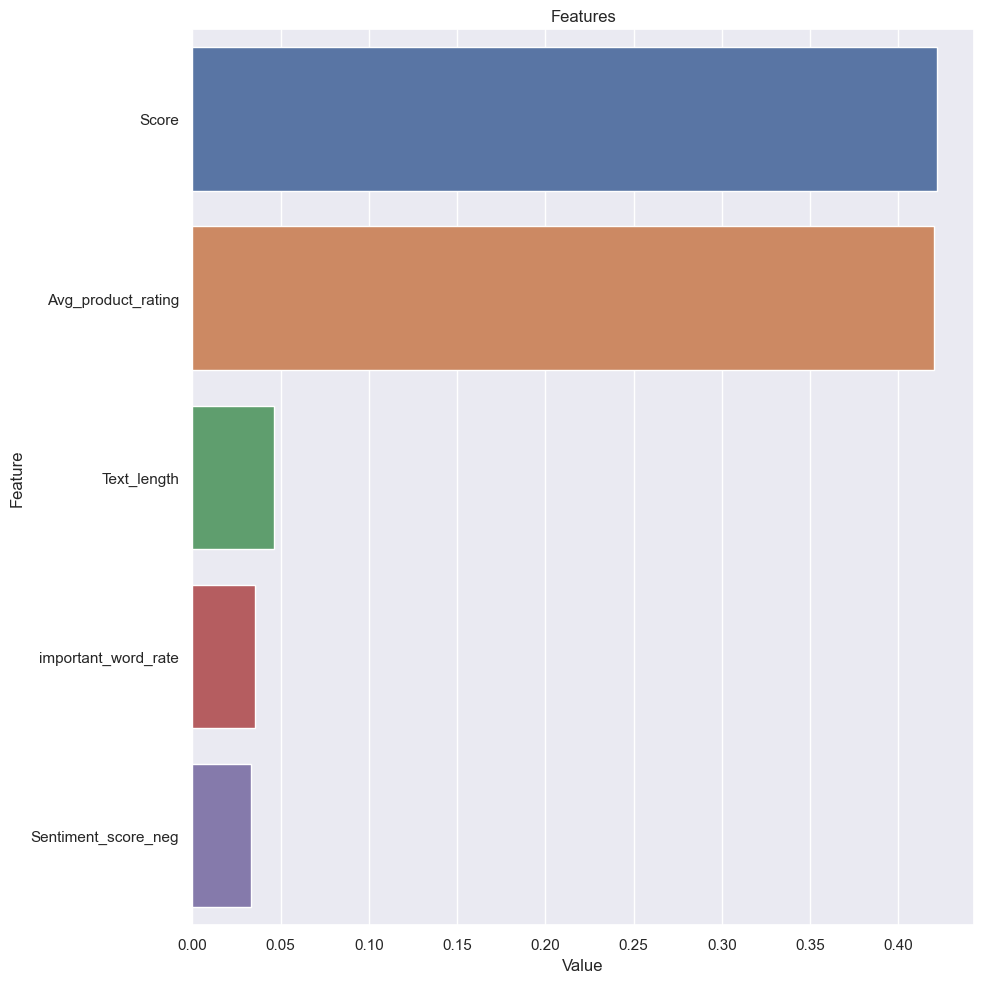

In [77]:
plot_importance(cart_model_2, X, num=5)

In [78]:
from sklearn.ensemble import GradientBoostingRegressor

In [79]:
gbm_model = GradientBoostingRegressor(random_state=1)

In [80]:
gbm_model_1 = GradientBoostingRegressor(random_state=1).fit(X_train,y_train)

C:\Users\90535\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [81]:
cv_results_4 = cross_validate(gbm_model_1,
                            X_train, y_train,
                            cv=10,
                            scoring=["r2","neg_mean_squared_error"])

C:\Users\90535\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\90535\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\90535\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\90535\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [82]:
print(cv_results_4['test_r2'].mean())
print(- cv_results_4['test_neg_mean_squared_error'].mean())

0.3285842425963071
0.0970789488807561


In [83]:
y_pred_4 = gbm_model_1.predict(X_test)

In [84]:
(mean_squared_error(y_test, y_pred_4))

0.09853286048168175

In [85]:
gbm_model_1.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 1,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [86]:
gbm_params = {'max_depth': range(1, 6),
               "min_samples_split": range(2, 5),
               "loss" : ["squared_error","huber"],
               "n_estimators" : [100,125,150],
               "criterion":["friedman_mse", "squared_error"]}

In [87]:
gbm_best_grid = GridSearchCV(gbm_model_1,
                              gbm_params,
                              cv=5,
                              n_jobs=-1,
                              verbose=1).fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


C:\Users\90535\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [88]:
gbm_model_2 = GradientBoostingRegressor(**gbm_best_grid.best_params_, random_state=1).fit(X_train, y_train)

C:\Users\90535\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [89]:
cv_results_5 = cross_validate(gbm_model_2,
                            X_train, y_train,
                            cv=10,
                            scoring=["r2","neg_mean_squared_error"])

C:\Users\90535\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\90535\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\90535\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\90535\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [90]:
y_pred_5 = gbm_model_2.predict(X_test)

In [91]:
(mean_squared_error(y_test, y_pred_5))

0.09979318399630353

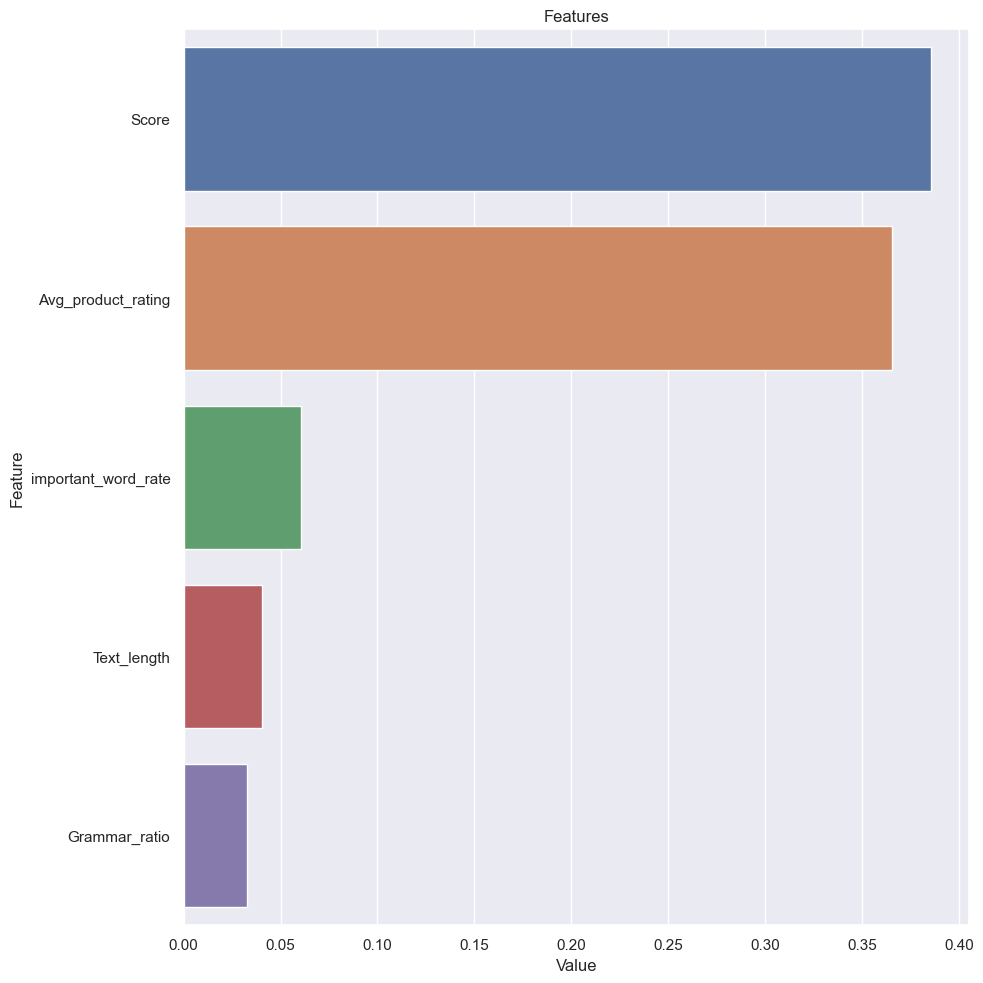

In [92]:
plot_importance(gbm_model_2, X, num=5)

In [93]:
mean_squared_erros = [mean_squared_error(y_test, y_pred_1),mean_squared_error(y_test, y_pred_2),mean_squared_error(y_test, y_pred_3),mean_squared_error(y_test, y_pred_4),mean_squared_error(y_test, y_pred_5)]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


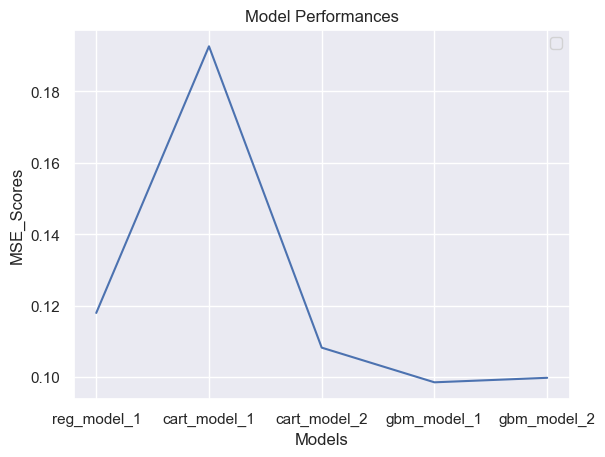

In [94]:
x_axis = ['reg_model_1', 'cart_model_1', 'cart_model_2', "gbm_model_1","gbm_model_2"]
y_mean_squared = mean_squared_erros
plt.plot(x_axis, y_mean_squared)
plt.title('Model Performances')
plt.xlabel('Models')
plt.ylabel('MSE_Scores')
plt.legend()
plt.show()

In [95]:
model_1_mse = np.square(y_test.to_numpy() - y_pred_1)
model_2_mse = np.square(y_test.to_numpy() - y_pred_2)
model_3_mse = np.square(y_test.to_numpy() - y_pred_3)
model_4_mse = np.square(y_test.to_numpy() - y_pred_4)
model_5_mse = np.square(y_test.to_numpy() - y_pred_5)


In [96]:
test_stat1, p_value_1 = ttest_ind(model_1_mse.flatten(),model_2_mse.flatten())
test_stat2, p_value_2 = ttest_ind(model_1_mse.flatten(),model_3_mse.flatten())
test_stat3, p_value_3 = ttest_ind(model_1_mse.flatten(),model_4_mse.flatten())
test_stat4, p_value_4 = ttest_ind(model_1_mse.flatten(),model_5_mse.flatten())



In [97]:
df_mse = pd.DataFrame({"p_values": [p_value_1, p_value_2,p_value_3,p_value_4],
        "test_values": [test_stat1, test_stat2,test_stat3,test_stat4],} , index=["cart_model_1", "cart_model_2","gbm_model_1","gbm_model_2"])

In [98]:
df_mse

,p_values,test_values
cart_model_1,3.995045e-45,-14.097384
cart_model_2,1.065825e-23,-10.035696
gbm_model_1,1.575662e-19,-9.039632
gbm_model_2,9.057980e-21,-9.346800


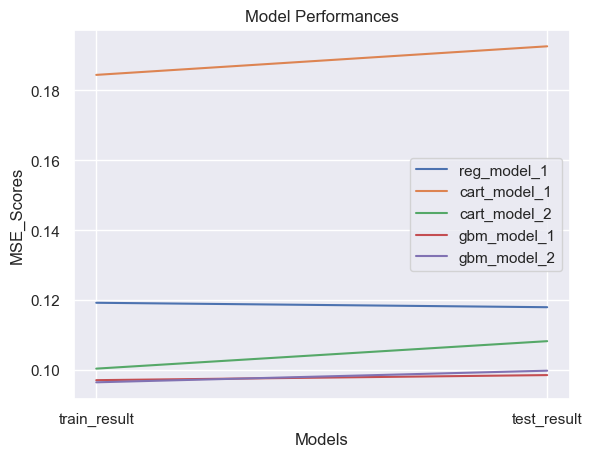

In [99]:
x_axis = ["train_result","test_result"]
model_1_tt = [-cv_results['test_neg_mean_squared_error'].mean(), mean_squared_error(y_test, y_pred_1)]
model_2_tt = [-cv_results_2['test_neg_mean_squared_error'].mean(), mean_squared_error(y_test, y_pred_2)]
model_3_tt = [-cv_results_3['test_neg_mean_squared_error'].mean(), mean_squared_error(y_test, y_pred_3)]
model_4_tt = [-cv_results_4['test_neg_mean_squared_error'].mean(), mean_squared_error(y_test, y_pred_4)]
model_5_tt = [-cv_results_5['test_neg_mean_squared_error'].mean(), mean_squared_error(y_test, y_pred_5)]

plt.plot(x_axis, model_1_tt, label = "reg_model_1")
plt.plot(x_axis, model_2_tt, label = "cart_model_1")
plt.plot(x_axis, model_3_tt, label = "cart_model_2")
plt.plot(x_axis, model_4_tt, label = "gbm_model_1")
plt.plot(x_axis, model_5_tt, label = "gbm_model_2")
plt.title('Model Performances')
plt.xlabel('Models')
plt.ylabel('MSE_Scores')
plt.legend()
plt.show()